In [2]:
import numpy as np
import time
from grid_world import standard_grid,negative_grid
SMALL_TOL=10e-10
ALL_Actions=['U','D','L','R',]
GAMMA=0.9
ALPHA=0.2
def print_values(V, g):
  print("Values:")
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  print("Policy:")
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")

In [3]:
def random_action(a, eps=0.1):
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_Actions)
def max_dict(d):
    max_key=None
    max_val=float('-inf')
    for k,v in d.items():
        if v>max_val:
            max_val=v
            max_key=k
    return max_key,max_val

In [4]:
SA2IDX = {}
IDX = 0

In [6]:
class Model:
    def __init__(self):
        self.theta = np.random.randn(25) / np.sqrt(25)
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # print "D:", IDX
    # self.theta = np.random.randn(IDX) / np.sqrt(IDX)

    def sa2x(self, s, a):
    # NOTE: using just (r, c, r*c, u, d, l, r, 1) is not expressive enough
        return np.array([
        s[0] - 1              if a == 'U' else 0,
        s[1] - 1.5            if a == 'U' else 0,
        (s[0]*s[1] - 3)/3     if a == 'U' else 0,
        (s[0]*s[0] - 2)/2     if a == 'U' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'U' else 0,
        1                     if a == 'U' else 0,
        s[0] - 1              if a == 'D' else 0,
        s[1] - 1.5            if a == 'D' else 0,
        (s[0]*s[1] - 3)/3     if a == 'D' else 0,
        (s[0]*s[0] - 2)/2     if a == 'D' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'D' else 0,
        1                     if a == 'D' else 0,
        s[0] - 1              if a == 'L' else 0,
        s[1] - 1.5            if a == 'L' else 0,
        (s[0]*s[1] - 3)/3     if a == 'L' else 0,
        (s[0]*s[0] - 2)/2     if a == 'L' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'L' else 0,
        1                     if a == 'L' else 0,
        s[0] - 1              if a == 'R' else 0,
        s[1] - 1.5            if a == 'R' else 0,
        (s[0]*s[1] - 3)/3     if a == 'R' else 0,
        (s[0]*s[0] - 2)/2     if a == 'R' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'R' else 0,
        1                     if a == 'R' else 0,
        1
    ])
    def predict(self, s, a):
        x = self.sa2x(s, a)
        return self.theta.dot(x)

    def grad(self, s, a):
        return self.sa2x(s, a)

In [12]:
def getQs(model, s):
    Qs = {}
    for a in ALL_Actions:
        q_sa = model.predict(s, a)
        Qs[a] = q_sa
    return Qs

Values:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


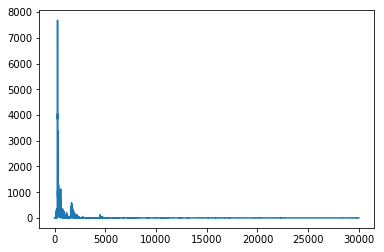

Values:
---------------------------
 0.18| 0.34| 0.51| 0.00|
---------------------------
-0.22| 0.00| 0.11| 0.00|
---------------------------
-0.32|-0.50|-0.55|-0.76|
Policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  U  |  U  |  U  |


In [30]:
grid = negative_grid(step_cost=-0.1)
# grid=standard_grid()
print_values(grid.rewards, grid)

states = grid.all_states()
for s in states:
    SA2IDX[s] = {}
    for a in ALL_Actions:
        SA2IDX[s][a] = IDX
        IDX += 1

# initialize model
model = Model()

# repeat until convergence
t = 1.0
t2 = 1.0
deltas = []
for it in range(30000):
    if it % 100 == 0:
        t += 0.001
        t2 += 0.001
    if it % 1000 == 0:
        print("it:", it,end='\r')
    alpha = ALPHA / t2

    s = (2, 0) # start state
    grid.set_state(s)
    Qs = getQs(model, s)

    a = max_dict(Qs)[0]
    a = random_action(a, eps=0.5/t) # epsilon-greedy
    biggest_change = 0
    
    while not grid.game_over():
        r = grid.move(a)
        s2 = grid.current_state()
        old_theta = model.theta.copy()
        if grid.is_terminal(s2):
            model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
        else:
            Qs2 = getQs(model, s2)
            a2 = max_dict(Qs2)[0]
            a2 = random_action(a2, eps=0.5/t) # epsilon-greedy
            model.theta += alpha*(r + GAMMA*model.predict(s2, a2) - model.predict(s, a))*model.grad(s, a)
            s = s2
            a = a2
        biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
    deltas.append(biggest_change)

plt.plot(deltas)
plt.show()

# determine the policy from Q*
# find V* from Q*
policy = {}
V = {}
Q = {}
for s in grid.actions.keys():
    Qs = getQs(model, s)
    Q[s] = Qs
    a, max_q = max_dict(Qs)
    policy[s] = a
    V[s] = max_q


print_values(V, grid)
print_policy(policy, grid)